# Hop Teaming Analysis - Attempt at geolocation

## Team: The Hindenburgs

Tomo Umer

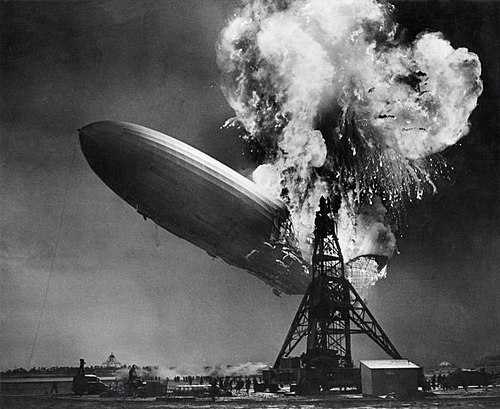

In [1]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import json
import time
import geopandas as gpd
from shapely.geometry import Point
import shapely
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
louvain_community = pd.read_csv('../data/louvain_community.csv')

In [4]:
louvain_community.head()

,name,communityId
0,1003013160,1448
1,1003013947,5724
2,1003019902,7592
3,1003028770,7643
4,1003031261,1018


Only 22 communities have 10 or more NPIs within and they correspond to 7788 NPIs (out of a total 8308, so only missing 520)

In [3]:
npi_communities = tuple(louvain_community['name'].tolist())

query =f"""
SELECT *
FROM nnpes
WHERE npi IN {npi_communities}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    communities = pd.read_sql(query, db)

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy
0,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,None,CLARKSVILLE,TN,37043,207Q00000X
1,1003013947,1.0,None,OTTO,ROBERT,JOEL,DR.,None,M.D.,2400 PATTERSON ST STE 100,None,NASHVILLE,TN,37203,207X00000X
2,1003019902,1.0,None,ACOSTA,LEALANI,MAE,None,None,MD,3601 TVC,None,NASHVILLE,TN,37232,2084N0400X
3,1003028770,2.0,SPRING HILL DERMATOLOGY PLC,None,None,None,None,None,None,1229 RESERVE BLVD,SUITE 200,SPRING HILL,TN,37174,207N00000X
4,1003031261,1.0,None,RUBRIGHT,JAMES,HARDMAN,None,None,M.D.,345 23RD AVE N,SUITE 212,NASHVILLE,TN,37203,207XS0106X


In [5]:
communities = pd.merge(left = communities, right = louvain_community, 
                        left_on = 'npi', right_on = 'name')

communities = communities.drop(columns='name')

In [ ]:
# testing the regex
# communities.loc[communities['first_line_address'].str.contains(' AT.')]

In [ ]:
# This below is needed because around 1250 addresses have STE in the first address line and that is not usable with nominatim openstreetmap
# communities['first_line_address'] = communities['first_line_address'].str.replace(' STE.+', '', regex=True)

# another 104 that end in ST + number
# communities['first_line_address'] = communities['first_line_address'].str.replace(' ST\d.+', '', regex=True)

# 7 with appartments
# communities['first_line_address'] = communities['first_line_address'].str.replace(' APT.', '', regex=True)

In [6]:
# adding the two new columns that will have the lat and long
communities['lat'] = ''
communities['lng'] = ''

In [ ]:
# this was for testing single iteration
# endpoint = 'https://nominatim.openstreetmap.org/search'

# params = {
#     'street' : communities.loc[0 ,'first_line_address'],
#     'city' : communities.loc[0, 'address_city_name'],
#     'state' : communities.loc[0, 'address_state_name'],
#     'postalcode' : communities.loc[0, 'address_postal_code'],
#     'format' : 'json'
# }

# response = requests.get(endpoint, params = params)

# print(response.url)
# print(response.status_code)

# if response.json() != []:
#     print(response.json()[0]['lat'])
#     print(response.json()[0]['lon'])


> NOTE: the function below was for openstreetmap

In [ ]:
# def latlong_go_getter(street, city, state, zip):
#     endpoint = 'https://nominatim.openstreetmap.org/search'

#     params = {
#     'street' : street,
#     'city' : city,
#     'state' : state,
#     'postalcode' : zip,
#     'format' : 'json'
#     }
    
#     response = requests.get(endpoint, params = params)
#     tm=0

#     while response.status_code != 200:
#         print('waiting for ' + street)
#         time.sleep(10)
#         response = requests.get(endpoint, params = params)
#         tm = tm + 1
#         if tm == 10:
#             break

#     results = response.json()

#     if results:
#         return results[0]['lat'], results[0]['lon']
#     else:
#         return '', ''


> NOTE: the code below takes about an hour to run!!

In [ ]:
# communities[['lat', 'lng']] = communities.apply(lambda row: pd.Series(latlong_go_getter(row['first_line_address'], row['address_city_name'], row['address_state_name'], row['address_postal_code'])), axis=1)

Redoing the same from above, but using google instead!

In [ ]:
with open('../keys.json') as fi:
    credentials = json.load(fi)

In [ ]:
api_key = credentials['api_key']

In [ ]:
def latlong_googler(street, city, state, zip):
    endpoint = 'https://maps.googleapis.com/maps/api/geocode/json'

    params = {
    'address' : street + ', ' + city  + ', ' + state  + ', ' + zip,
    'key' : api_key
    }
    
    response = requests.get(endpoint, params = params)
    tm=0

    while response.status_code != 200:
        print('waiting for ' + street)
        time.sleep(10)
        response = requests.get(endpoint, params = params)
        tm = tm + 1
        if tm == 10:
            break

    results = response.json()

    if results:
        return results['results'][0]['geometry']['location']['lat'], results['results'][0]['geometry']['location']['lng']
    else:
        return '', ''

> NOTE: running the code below takes about an hour!! so only uncomment the first time and then save to csv

In [ ]:
#communities['address_postal_code'].dtype

The code below takes about 20 min to run! So google makes it about 3x as faster as openmaps! AND it found all addresses, without even having to regex it!

In [ ]:
#communities[['lat', 'lng']] = communities.apply(lambda row: pd.Series(latlong_googler(row['first_line_address'], row['address_city_name'], row['address_state_name'], row['address_postal_code'])), axis=1)

In [ ]:
#communities.to_csv('../data/communities_googlemap.csv')

In [9]:
# Initially I ran the geospatial on only large communities
small_communities = pd.read_csv('../data/small_communities_googlemap.csv').drop(columns='Unnamed: 0')
communities = pd.read_csv('../data/communities_googlemap.csv').drop(columns='Unnamed: 0')

In [12]:
communities = pd.concat([small_communities,communities])

In [13]:
communities

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,communityId,lat,lng
0,1003297318,1.0,NaN,GOZUM,VIRGILIO,P,DR.,NaN,O.D.,5238 MAIN ST,NaN,SPRING HILL,TN,37174,152W00000X,4270,35.754979,-86.925748
1,1003359233,2.0,"BERRY FARMS EYECARE, PLLC",NaN,NaN,NaN,NaN,NaN,NaN,40 MOSS LN STE 110,NaN,FRANKLIN,TN,37064,152W00000X,8003,35.861637,-86.844781
2,1003875824,1.0,NaN,SANDS,ALADRAINE,NaN,NaN,NaN,M.D.,275 CUMBERLAND BND,NaN,NASHVILLE,TN,37228,207R00000X,4558,36.193784,-86.787897
3,1003890609,1.0,NaN,JOHNSON,TRAVIS,M.,DR.,NaN,O.D.,140 JOE B JACKSON PKWY,NaN,MURFREESBORO,TN,37127,152W00000X,7944,35.775151,-86.399903
4,1013116169,2.0,FRANKLIN CHIROPRACTIC CENTER LLC,NaN,NaN,NaN,NaN,NaN,NaN,128 HOLIDAY CT STE 107,NaN,FRANKLIN,TN,37067,111N00000X,502,35.917912,-86.824578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,1992972087,2.0,INTERNAL MEDICINE ASSOCIATES OF SOUTHERN HILLS...,NaN,NaN,NaN,NaN,NaN,NaN,393 WALLACE RD,SUITE 104-A,NASHVILLE,TN,37211,207R00000X,5724,36.076174,-86.722457
7784,1992978845,1.0,NaN,CHILDS,ADAM,M,DR.,NaN,M.D.,2933 MEDICAL CENTER PKWY,SUITE A,MURFREESBORO,TN,37129,207Q00000X,7967,35.865845,-86.448895
7785,1992985055,2.0,FAMILY CARE OF MIDDLETENNESSEE,NaN,NaN,NaN,NaN,NaN,NaN,713A PRESIDENT PL,NaN,SMYRNA,TN,37167,174400000X,2322,35.978948,-86.558737
7786,1992985949,1.0,NaN,BECK,ROBERT,L,MR.,JR.,M.D,2400 PATTERSON ST,SUITE 400,NASHVILLE,TN,37203,207R00000X,5724,36.153216,-86.809115


In [ ]:
# missing 2057 addresses!
#communities = communities.loc[~communities['lat'].isna()]

Downloaded the CBSA shapefile from:
https://catalog.data.gov/dataset/tiger-line-shapefile-2020-nation-u-s-core-based-statistical-areas-cbsa

In [14]:
# load in ALL of the CBSA (from all of us)
cbsa_34980 = gpd.read_file('../data/tl_2020_us_cbsa/tl_2020_us_cbsa.shp')

# select only the one we're interested in
cbsa_34980 = cbsa_34980.loc[cbsa_34980['CBSAFP'] == '34980']

In [15]:
communities['geometry'] = gpd.points_from_xy(communities['lng'], communities['lat'])

communities.head()

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,second_line_address,address_city_name,address_state_name,address_postal_code,primary_taxonomy,communityId,lat,lng,geometry
0,1003297318,1.0,NaN,GOZUM,VIRGILIO,P,DR.,NaN,O.D.,5238 MAIN ST,NaN,SPRING HILL,TN,37174,152W00000X,4270,35.754979,-86.925748,POINT (-86.92575 35.75498)
1,1003359233,2.0,"BERRY FARMS EYECARE, PLLC",NaN,NaN,NaN,NaN,NaN,NaN,40 MOSS LN STE 110,NaN,FRANKLIN,TN,37064,152W00000X,8003,35.861637,-86.844781,POINT (-86.84478 35.86164)
2,1003875824,1.0,NaN,SANDS,ALADRAINE,NaN,NaN,NaN,M.D.,275 CUMBERLAND BND,NaN,NASHVILLE,TN,37228,207R00000X,4558,36.193784,-86.787897,POINT (-86.78790 36.19378)
3,1003890609,1.0,NaN,JOHNSON,TRAVIS,M.,DR.,NaN,O.D.,140 JOE B JACKSON PKWY,NaN,MURFREESBORO,TN,37127,152W00000X,7944,35.775151,-86.399903,POINT (-86.39990 35.77515)
4,1013116169,2.0,FRANKLIN CHIROPRACTIC CENTER LLC,NaN,NaN,NaN,NaN,NaN,NaN,128 HOLIDAY CT STE 107,NaN,FRANKLIN,TN,37067,111N00000X,502,35.917912,-86.824578,POINT (-86.82458 35.91791)


In [16]:
communities_geo = gpd.GeoDataFrame(communities, 
                                    crs = cbsa_34980.crs, 
                                    geometry = communities['geometry'])

In [17]:
topcommunities_geo = communities_geo.loc[communities_geo['communityId'].isin([7592,5724,5295,1018,7643])] #sixth one 7967

In [18]:
def ranking(x):
  if x['communityId'] == 7592: return '1st Community'
  elif x['communityId'] == 5724: return '2nd Community'
  elif x['communityId'] == 5295: return '3rd Community'
  elif x['communityId'] == 1018: return '4th Community'
  elif x['communityId'] == 7643: return '5th Community'
  else: return 'none'

topcommunities_geo['community_rank'] = topcommunities_geo.apply(ranking, axis=1)

/Users/tomoumer/opt/anaconda3/envs/geospatial_ds6/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Finally, adding counties below:

In [19]:
counties = gpd.read_file('../data/tl_2016_47_cousub/tl_2016_47_cousub.shp')

In [20]:
counties.head(5)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,053,90054,02464232,4705390054,1,District 1,28,Z1,G4040,None,None,None,N,96264311,137578,+35.8364702,-088.7717523,"POLYGON ((-88.84931 35.84546, -88.84925 35.846..."
1,47,053,91764,02464308,4705391764,10,District 10,28,Z1,G4040,None,None,None,N,10508081,0,+35.9588678,-088.9411265,"POLYGON ((-88.95553 35.96024, -88.95544 35.960..."
2,47,053,91954,02464338,4705391954,11,District 11,28,Z1,G4040,None,None,None,N,217597201,1369276,+35.9897003,-088.7783091,"POLYGON ((-88.89445 35.95602, -88.89384 35.956..."
3,47,053,92144,02464357,4705392144,12,District 12,28,Z1,G4040,None,None,None,N,31322917,7879,+35.8879687,-088.7372825,"POLYGON ((-88.79699 35.88976, -88.79654 35.889..."
4,47,059,90630,02464038,4705990630,4,District 4,28,Z1,G4040,None,None,None,N,229945651,1986997,+36.0742786,-082.7712694,"POLYGON ((-82.86306 36.06660, -82.86237 36.067..."


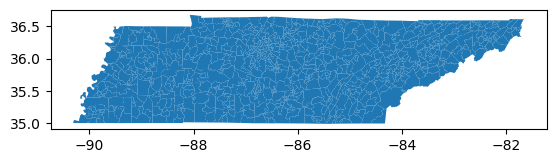

In [21]:
counties.plot();

County codes:
- Bedford 003
- Davidson 037
- Wilson 189
- Williamson 187
- Ruhterford 149
- Marshall 117
- Maury 119
- Cannon 015
- Warren 177
- DeKalb 041
- Smith 159
- Macon 111
- Sumner 165
- Trousedale 169
- Robertson 147
- Montgomery 125
- Cheatham 021
- Dickson 043
- Hickman 081
- Giles 055
- Lawrence 099

In [22]:
relevant_counties = ['003', '015', '021', '037', '041', '043', '055', '081', '099', '111', '117', '119', '125', '147', '159', '165', '169', '177', '189', '187', '149']

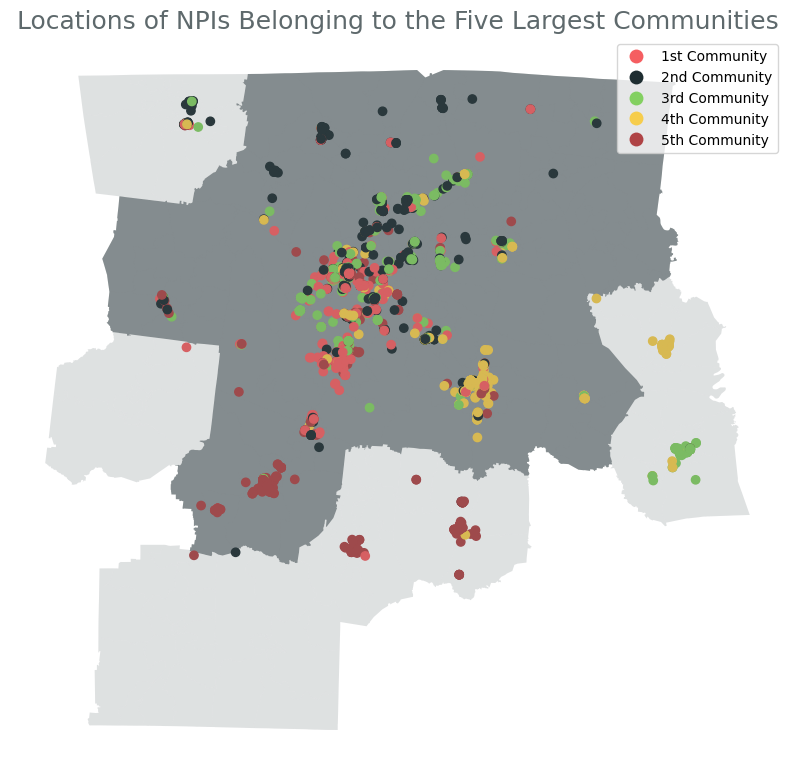

In [23]:
ax = cbsa_34980.plot(figsize=(10,10), color = '#5E696C', alpha=0.7)
topcommunities_geo.loc[topcommunities_geo['lng'] < -84].plot(ax = ax, column= 'community_rank', cmap = ListedColormap(['#F55E61', '#1E2D31', '#83D061', '#F6CD4C', '#AF4345']), legend='True') #edgecolor = 'black' 
counties.loc[counties['COUNTYFP'].isin(relevant_counties)].plot(ax=ax, color = '#5E696C', alpha=0.2)
plt.title('Locations of NPIs Belonging to the Five Largest Communities', fontsize = 18, color='#5E696C')
ax.axis('off');

Now trying to count npis within different counties.

In [31]:
npis_by_county = gpd.sjoin(communities_geo, counties, predicate = 'within')
#these three below have a vandy hospital in
vandynpis_by_county = gpd.sjoin(communities_geo.loc[communities_geo['communityId'].isin([7592,7643,2322])], counties, predicate = 'within')

In [32]:
# npis_by_county = npis_by_county[['COUNTYFP', 'NAME']].value_counts().to_frame().reset_index().rename(columns={0:'count_npi'})
# vandynpis_by_county = vandynpis_by_county[['COUNTYFP', 'NAME']].value_counts().to_frame().reset_index().rename(columns={0:'count_vandynpi'})

In [33]:
npis_by_county = npis_by_county['COUNTYFP'].value_counts().to_frame().reset_index().rename(columns={'index':'COUNTYFP', 'COUNTYFP':'count_npi'})
vandynpis_by_county = vandynpis_by_county['COUNTYFP'].value_counts().to_frame().reset_index().rename(columns={'index':'COUNTYFP', 'COUNTYFP':'count_vandynpi'})

In [34]:
interesting_counties = counties.loc[counties['COUNTYFP'].isin(relevant_counties)]

In [35]:
interesting_counties = pd.merge(left = interesting_counties, right = npis_by_county, 
                    left_on = 'COUNTYFP', right_on = 'COUNTYFP')

interesting_counties = pd.merge(left = interesting_counties, right = vandynpis_by_county, 
                    left_on = 'COUNTYFP', right_on = 'COUNTYFP', how='left')

interesting_counties['count_vandynpi'] = interesting_counties['count_vandynpi'].fillna(0)

In [36]:
# interesting_counties = pd.merge(left = interesting_counties, right = npis_by_county, 
#                     left_on = ['COUNTYFP', 'NAME'], right_on = ['COUNTYFP', 'NAME'])

# interesting_counties = pd.merge(left = interesting_counties, right = vandynpis_by_county, 
#                     left_on = ['COUNTYFP', 'NAME'], right_on = ['COUNTYFP', 'NAME'], how='left')

# interesting_counties['count_vandynpi'] = interesting_counties['count_vandynpi'].fillna(0)

In [37]:
interesting_counties['vandy_share'] = interesting_counties['count_vandynpi'] / interesting_counties['count_npi']

In [38]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(67/256, 245/256, N) #94 #30
vals[:, 1] = np.linspace(74/256, 94/256, N) #105 #45
vals[:, 2] = np.linspace(77/256, 97/256, N) #108 #49



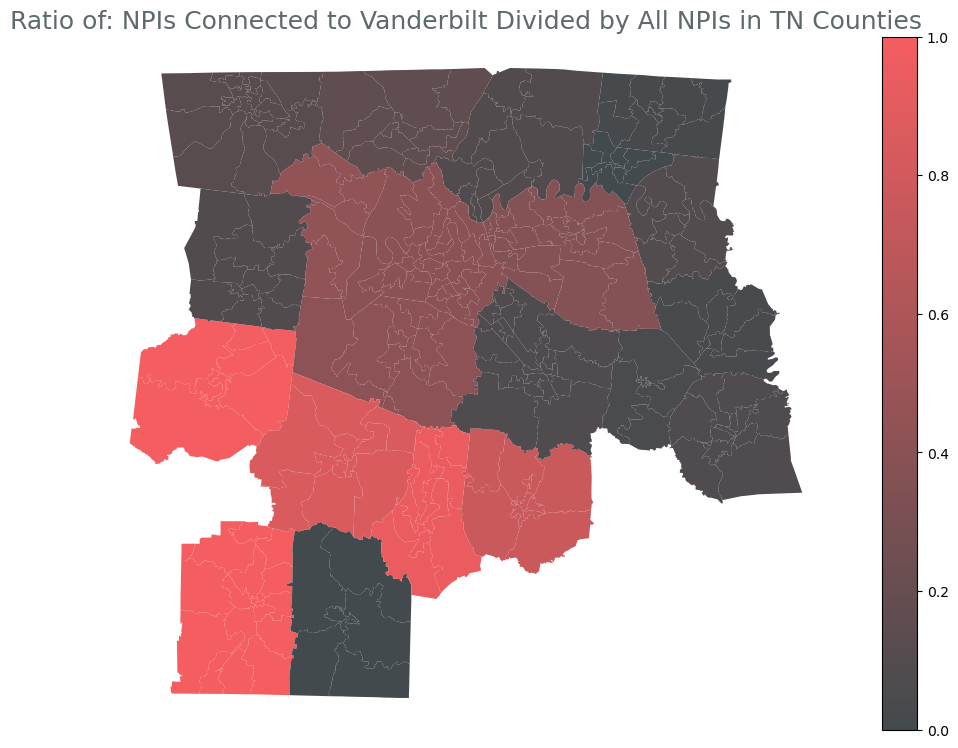

In [39]:
fig, ax = plt.subplots(figsize=(12,9))
interesting_counties.plot(column = 'vandy_share', cmap = ListedColormap(vals) , legend= True, ax = ax)
#cmap = ListedColormap(['#1E2D31','#273C42','#5E696C','#AF4345','#F55E61','#F58F8F','#83D061','#F6CD4C'])
plt.title('Ratio of: NPIs Connected to Vanderbilt Divided by All NPIs in TN Counties', fontsize = 18, color='#5E696C')
ax.axis('off');